Notebook for anlayzing how performance on a test set changes with choice of neighbor set

In [17]:
import torch 
from models import NONA_FT, NONA
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from ft_eval import RSNADataset, get_fold_indices, load_data_params
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torcheval.metrics.functional import mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split
import pickle as pkl

In [2]:
device = torch.device('cpu')
res = resnet18(weights='DEFAULT')

model_type = 'nona euclidean'
pred_sim = model_type.split(" ")
if len(pred_sim)==2:
    predictor_head = pred_sim[0]
    sim = pred_sim[1]
else:
    predictor_head= model_type 
    sim = None

model=NONA_FT(feature_extractor=res, 
                        hl_sizes=[200,50], 
                        predictor=predictor_head, 
                        similarity=sim, 
                        task='regression', 
                        dtype=torch.float32)

In [3]:
seed = 0
rsna_sft_weights = torch.load(f'results/rsna/models/02231621/{model_type}_{seed}.pth', map_location=device)
model.load_state_dict(rsna_sft_weights)

<All keys matched successfully>

In [4]:
task, data_df, transform, fe, data_percentage = load_data_params('rsna')
idx_dict = get_fold_indices(data_df=data_df, seed=seed, data_percentage=data_percentage)

In [5]:
def collate(batch):
    x, y = zip(*batch)
    x = torch.stack(x).to(device).to(torch.float32)
    y = torch.tensor(y, dtype=torch.float32, device=device)
    return x, y

In [6]:
test_dataset = RSNADataset(idx_dict['test'], transform=transform)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True, collate_fn=collate)

train_dataset = RSNADataset(idx_dict['train'], transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False, collate_fn=collate)

In [7]:
for i, (X, y) in enumerate(test_loader):
    if i == 0:
        X_dummy = X[:2]
        y_dummy = y[:2]

Using different percentages of data unused by the model as neighbors for the test set

In [10]:
unused_data = data_df[data_df['id'].isin(idx_dict['unused'])]
unused_ids = unused_data['id']
unused_labels = unused_data['boneage binned']

with torch.no_grad():
    for X_test, y_test in test_loader:
        _, test_embeddings = model(X_test, X_dummy, y_dummy, get_embeddings=True)

nona_head = NONA(dtype=torch.float32)

scores = {'mse': [], 'mae': []}
for perc in range(1,20):
    test_size = perc / 20
    _, neighbor_ids, _, _ = train_test_split(unused_ids, unused_labels, test_size=test_size, stratify=unused_labels, random_state=38)

    neighbor_dataset = RSNADataset(neighbor_ids, transform=transform)
    neighbor_loader = DataLoader(neighbor_dataset, batch_size=128, shuffle=False, collate_fn=collate)
    print(len(neighbor_dataset), 'neighbors')

    X_n_list = []
    y_n_list = []
    with torch.no_grad():
        for X_neighbors, y_neighbors in neighbor_loader:
            _, neighbor_embeddings = model(X_neighbors, X_dummy, y_dummy, get_embeddings=True)
            X_n_list.append(neighbor_embeddings)
            y_n_list.append(y_neighbors)
    
    X_n = torch.cat(X_n_list, dim=0)
    y_n = torch.cat(y_n_list, dim=0)

    y_hat = nona_head(test_embeddings, X_n, y_n)
    
    mse = torch.mean((y_test - y_hat) ** 2)
    scores['mse'].append(mse.item())

    mae = torch.mean(torch.abs(y_test - y_hat))
    scores['mae'].append(mae.item())

    print(scores)

615 neighbors
{'mse': [0.00827864184975624], 'mae': [0.06933006644248962]}
1229 neighbors
{'mse': [0.00827864184975624, 0.008270974270999432], 'mae': [0.06933006644248962, 0.06935581564903259]}
1843 neighbors
{'mse': [0.00827864184975624, 0.008270974270999432, 0.008292236365377903], 'mae': [0.06933006644248962, 0.06935581564903259, 0.06954166293144226]}
2457 neighbors
{'mse': [0.00827864184975624, 0.008270974270999432, 0.008292236365377903, 0.008381393738090992], 'mae': [0.06933006644248962, 0.06935581564903259, 0.06954166293144226, 0.06994593888521194]}
3071 neighbors
{'mse': [0.00827864184975624, 0.008270974270999432, 0.008292236365377903, 0.008381393738090992, 0.008381875231862068], 'mae': [0.06933006644248962, 0.06935581564903259, 0.06954166293144226, 0.06994593888521194, 0.06997739523649216]}
3685 neighbors
{'mse': [0.00827864184975624, 0.008270974270999432, 0.008292236365377903, 0.008381393738090992, 0.008381875231862068, 0.008447998203337193], 'mae': [0.06933006644248962, 0.0693

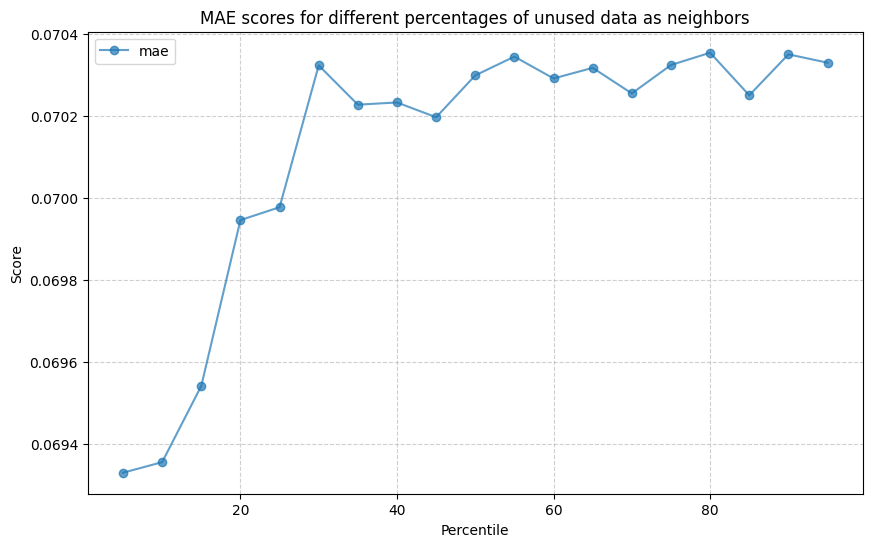

In [15]:
import matplotlib.pyplot as plt
import numpy as np

metric = 'mae'

# Assuming `scores` is your dictionary
# Each key is a label, and each value is a list of 19 percentages
percentiles = np.linspace(5, 95, 19)  # Generate x-axis values from 5% to 95%

plt.figure(figsize=(10, 6))


plt.plot(percentiles, scores[metric], marker='o', label=metric, alpha=0.7)

plt.xlabel("Percentile")
plt.ylabel("Score")
plt.title(f"{metric.upper()} scores for different percentages of unused data as neighbors")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [20]:
# with open(f"results/rsna/neighbors_at_inf/02231621_{model_type}_{seed}_unused.pkl", "wb") as file:
#     pkl.dump(scores, file)